# The basics of double/debiased machine learning
## 1.1 Data generating process（数据生成过程）
[DoubleML guide](https://docs.doubleml.org/stable/guide/basics.html#)


**Outcome equation（结果变量方程）**\
用于因果推断的模型，核心目的是对因果参数 $ \theta_0 $ 进行有效推断
$$ y_i = \theta_0 d_i + g_0(x_i) + \zeta_i, \quad \zeta_i \sim \mathcal{N}(0, 1) $$
- $y_i$ 是结果变量（outcome）
- $d_i$ 是处理变量（treatment）
- $x_i$ 是协变量（covariates）
- $g_0(x_i)$ 是协变量的非参数效应（未知函数）
- $\zeta_i$ 是噪声项，服从标准正态分布

**Treatment equation（处理变量方程）**
$$ d_i = m_0(x_i) + v_i, \quad v_i \sim \mathcal{N}(0, 1) $$
- $m_0(x_i)$ 是协变量对处理变量的影响（也是未知函数）
- $v_i$ 是误差项，同样是标准正态分布

我们希望估计线性因果效应 $\theta_0$，但协变量 $x_i$ 的影响是非线性的，且不完全已知。

**nuisance functions（扰动函数）**
$$ m_0(x_i) = x_{i,1} + \frac{1}{4} \cdot \frac{\exp(x_{i,3})}{1 + \exp(x_{i,3})} $$
- $m_0(x_i)$ 是协变量对处理变量的影响
- $x_{i,1}$ 是协变量的第一个分量，对处理变量有线性影响
- $x_{i,3}$ 是协变量的第三个分量，对处理变量有非线性影响，所以使用了一个非线性函数这里使用sigmoid举例.非线性部分可能模拟选择偏差（selection bias），即某些协变量对处理分配的影响是非线性的。
- $\frac{1}{4}$是非线性部分的权重

$$ g_0(x_i) = \frac{\exp(x_{i,1})}{1 + \exp(x_{i,1})} + \frac{1}{4} x_{i,3}$$
- g_0(x_i) 是协变量对结果变量的影响
- $x_{i,1}$ 是协变量的第一个分量，对结果变量有非线性影响，这里使用了一个非线性函数（sigmoid）。
- $x_{i,3}$ 是协变量的第三个分量，对结果变量有线性影响




In [ ]:
# 在 Python 中，数据可以用 `doubleml.datasets.make_plr_CCDDHNR2018()` 生成。
import numpy as np
from doubleml.datasets import make_plr_CCDDHNR2018

np.random.seed(1234)
n_rep = 1000  # 重复次数，这里是生成1000个数据集
n_obs = 500  # 观测数
n_vars = 20  # 变量数
alpha = 0.5  # 相关性参数

# 生成数据集，这里使用的是CCDDHNR2018数据集的生成函数
data = list()

for i_rep in range(n_rep):
    (x, y, d) = make_plr_CCDDHNR2018(alpha=alpha, n_obs=n_obs, dim_x=n_vars, return_type='array')
    data.append((x, y, d))

# 查看生成的数据集的形状
for i in range(5):  # 只查看前5个数据集
    x, y, d = data[i]
    print(f"Data set {i+1}:")
    print(f"x shape: {x.shape}, y shape: {y.shape}, d shape: {d.shape}")

Data set 1:
x shape: (500, 20), y shape: (500,), d shape: (500,)
Data set 2:
x shape: (500, 20), y shape: (500,), d shape: (500,)
Data set 3:
x shape: (500, 20), y shape: (500,), d shape: (500,)
Data set 4:
x shape: (500, 20), y shape: (500,), d shape: (500,)
Data set 5:
x shape: (500, 20), y shape: (500,), d shape: (500,)


## 1.2 Regularization bias in simple ML-approaches 
  （简单机器学习方法中的正则化偏差）

基于直接应用机器学习方法来估计因果参数 $\theta_0$ 的简单推断通常是无效的。使用机器学习方法会引入由于正则化而产生的偏差。
一种简单的机器学习方法是将样本随机分成两部分。在辅助样本（索引为 $i \in I^C$）上，使用机器学习方法（例如随机森林学习器）估计扰动函数 $g_0(X)$。
给定估计值 $\hat{g}_0(X)$，最终的 $\theta_0$ 估计值通过使用另一半观测值（索引为 $i \in I$）计算得到，其中 $(n = N/2)$。

$$\hat{\theta}_0 = \left( \frac{1}{n} \sum_{i \in I} D_i^2 \right)^{-1} \frac{1}{n} \sum_{i \in I} D_i \left( Y_i - \hat{g}_0(X_i) \right)$$

- **$\hat{\theta}_0$**：这是我们希望估计的因果效应参数。
- **$n$**：样本大小，通常是观测数据的数量。
- **$I$**：样本的一个子集索引（例如，数据被分成两部分时的一个部分）。
- **$D_i$**：处理变量（treatment variable），表示第 $i$ 个样本的处理状态。
- **$Y_i$**：结果变量（outcome variable），表示第 $i$ 个样本的观测结果。
- **$\hat{g}_0(X_i)$**：协变量 $X_i$ 对结果变量 $Y_i$ 的预测值，通常是通过机器学习模型估计的。减去它可以消除协变量的干扰，从而更准确地估计因果效应。

这个公式的核心思想是通过去除协变量 $X_i$ 的影响，来估计处理变量 $D_i$ 对结果变量 $Y_i$ 的因果效应 $\theta_0$。通过分样本（cross-fitting）和机器学习方法估计 $\hat{g}_0(X_i)$，可以减少正则化偏差，提高估计的稳健性。

> **正则化偏差**是指在使用机器学习模型时，由于模型的正则化（regularization）策略而引入的系统性误差。正则化是一种防止模型过拟合的技术，通过对模型的复杂性施加约束（例如，L1/L2正则化、剪枝、早停等），使模型在训练数据上表现得更简单、更平滑。然而，这种约束可能导致模型对训练数据的拟合不足，从而引入偏差。\
> 在因果推断中，正则化偏差的影响尤为显著，因为我们不仅需要预测准确性，还需要对因果效应参数（如 $\theta_0$）进行无偏估计。具体来说：
> 1. **扰动函数的估计偏差**：在辅助样本上使用机器学习模型估计扰动函数（如 $g_0(X)$ 或 $m_0(X)$）时，正则化可能导致这些函数的估计值 $\hat{g}_0(X)$ 或 $\hat{m}_0(X)$ 偏离真实值。这种偏差会传递到因果效应参数的估计中。
> 2. **交叉拟合的必要性**：为了减少正则化偏差对因果效应估计的影响，通常采用交叉拟合（cross-fitting）技术。通过将样本分成两部分，分别用于估计扰动函数和计算因果效应，可以有效减少正则化偏差的累积。
> 3. **偏差-方差权衡**：正则化引入了偏差，但同时减少了模型的方差（即对训练数据的敏感性）。在因果推断中，过强的正则化可能导致因果效应估计的偏差过大，而过弱的正则化可能导致模型过拟合，从而增加估计的方差。
因此，正则化偏差是机器学习模型在因果推断中需要特别注意的问题。通过交叉拟合和适当的正则化强度，可以在偏差和方差之间取得平衡，从而提高因果效应估计的准确性和稳健性。


In [ ]:
def non_orth_score(y, d, l_hat, m_hat, g_hat, smpls):
    '''计算非正交得分函数的值'''
    u_hat = y - g_hat
    psi_a = -np.multiply(d, d)  # 求负得d的平方
    psi_b = np.multiply(d, u_hat)  # 求d和u_hat的乘积
    return psi_a, psi_b

In [ ]:
np.random.seed(1111)
from lightgbm import LGBMRegressor
from sklearn.base import clone
# sklearn.base.clone用于创建 estimators（估计器）的深拷贝（deep copy）的函数。
# 它的主要作用是复制一个 scikit-learn 模型或转换器，包括其所有参数
# 但不会复制训练数据（因为数据不属于模型的参数）。
from sklearn.model_selection import train_test_split
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
face_colors = sns.color_palette('pastel')
edge_colors = sns.color_palette('dark')
import warnings
warnings.filterwarnings("ignore")


ml_l = LGBMRegressor(n_estimators=300, learning_rate=0.1, verbose=-1)
ml_m = LGBMRegressor(n_estimators=300, learning_rate=0.1, verbose=-1)

ml_g = clone(ml_l)

theta_nonorth = np.full(n_rep, np.nan)  # theta_nonorth用于存储theta的值
se_nonorth = np.full(n_rep, np.nan)  # se_nonorth用于存储标准误差的值

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]

    # 将数据集分为训练集和测试集
    i_train, i_est = train_test_split(np.arange(n_obs), test_size=0.5, random_state=42)

    # 训练模型
    ml_l.fit(x[i_train, :], y[i_train])  # ml_l用于拟合y和x的关系
    ml_m.fit(x[i_train, :], d[i_train])  # ml_m用于拟合d和x的关系

    psi_a = -np.multiply(d[i_train] - ml_m.predict(x[i_train, :]),  # d的实际值减去预测值的平方（负）
                         d[i_train] - ml_m.predict(x[i_train, :]))  # 也就是处理变量的方差
    # 下面计算的就是$D_i \left( Y_i - \hat{g}_0(X_i) \right)$
    psi_b = np.multiply(d[i_train] - ml_m.predict(x[i_train, :]),  # （d的实际值减去预测值）与 
                        y[i_train] - ml_l.predict(x[i_train, :]))  # （y的实际值减去预测值）的乘积
    theta_initial = -np.nanmean(psi_b) / np.nanmean(psi_a)  # np.nanmean用于计算均值，忽略NaN值
    ml_g.fit(x[i_train, :], y[i_train] - theta_initial * d[i_train])

    # create out-of-sample predictions
    l_hat = ml_l.predict(x[i_est, :])
    m_hat = ml_m.predict(x[i_est, :])
    g_hat = ml_g.predict(x[i_est, :])

    external_predictions = {
        'd': {
            'ml_l': l_hat.reshape(-1, 1),
            'ml_m': m_hat.reshape(-1, 1),
            'ml_g': g_hat.reshape(-1, 1)
        }
    }

    obj_dml_data = DoubleMLData.from_arrays(x[i_est, :], y[i_est], d[i_est])
    obj_dml_plr_nonorth = DoubleMLPLR(obj_dml_data,
                                    ml_l, ml_m, ml_g,
                                    n_folds=2,
                                    score=non_orth_score)
    obj_dml_plr_nonorth.fit(external_predictions=external_predictions)
    theta_nonorth[i_rep] = obj_dml_plr_nonorth.coef[0]
    se_nonorth[i_rep] = obj_dml_plr_nonorth.se[0]


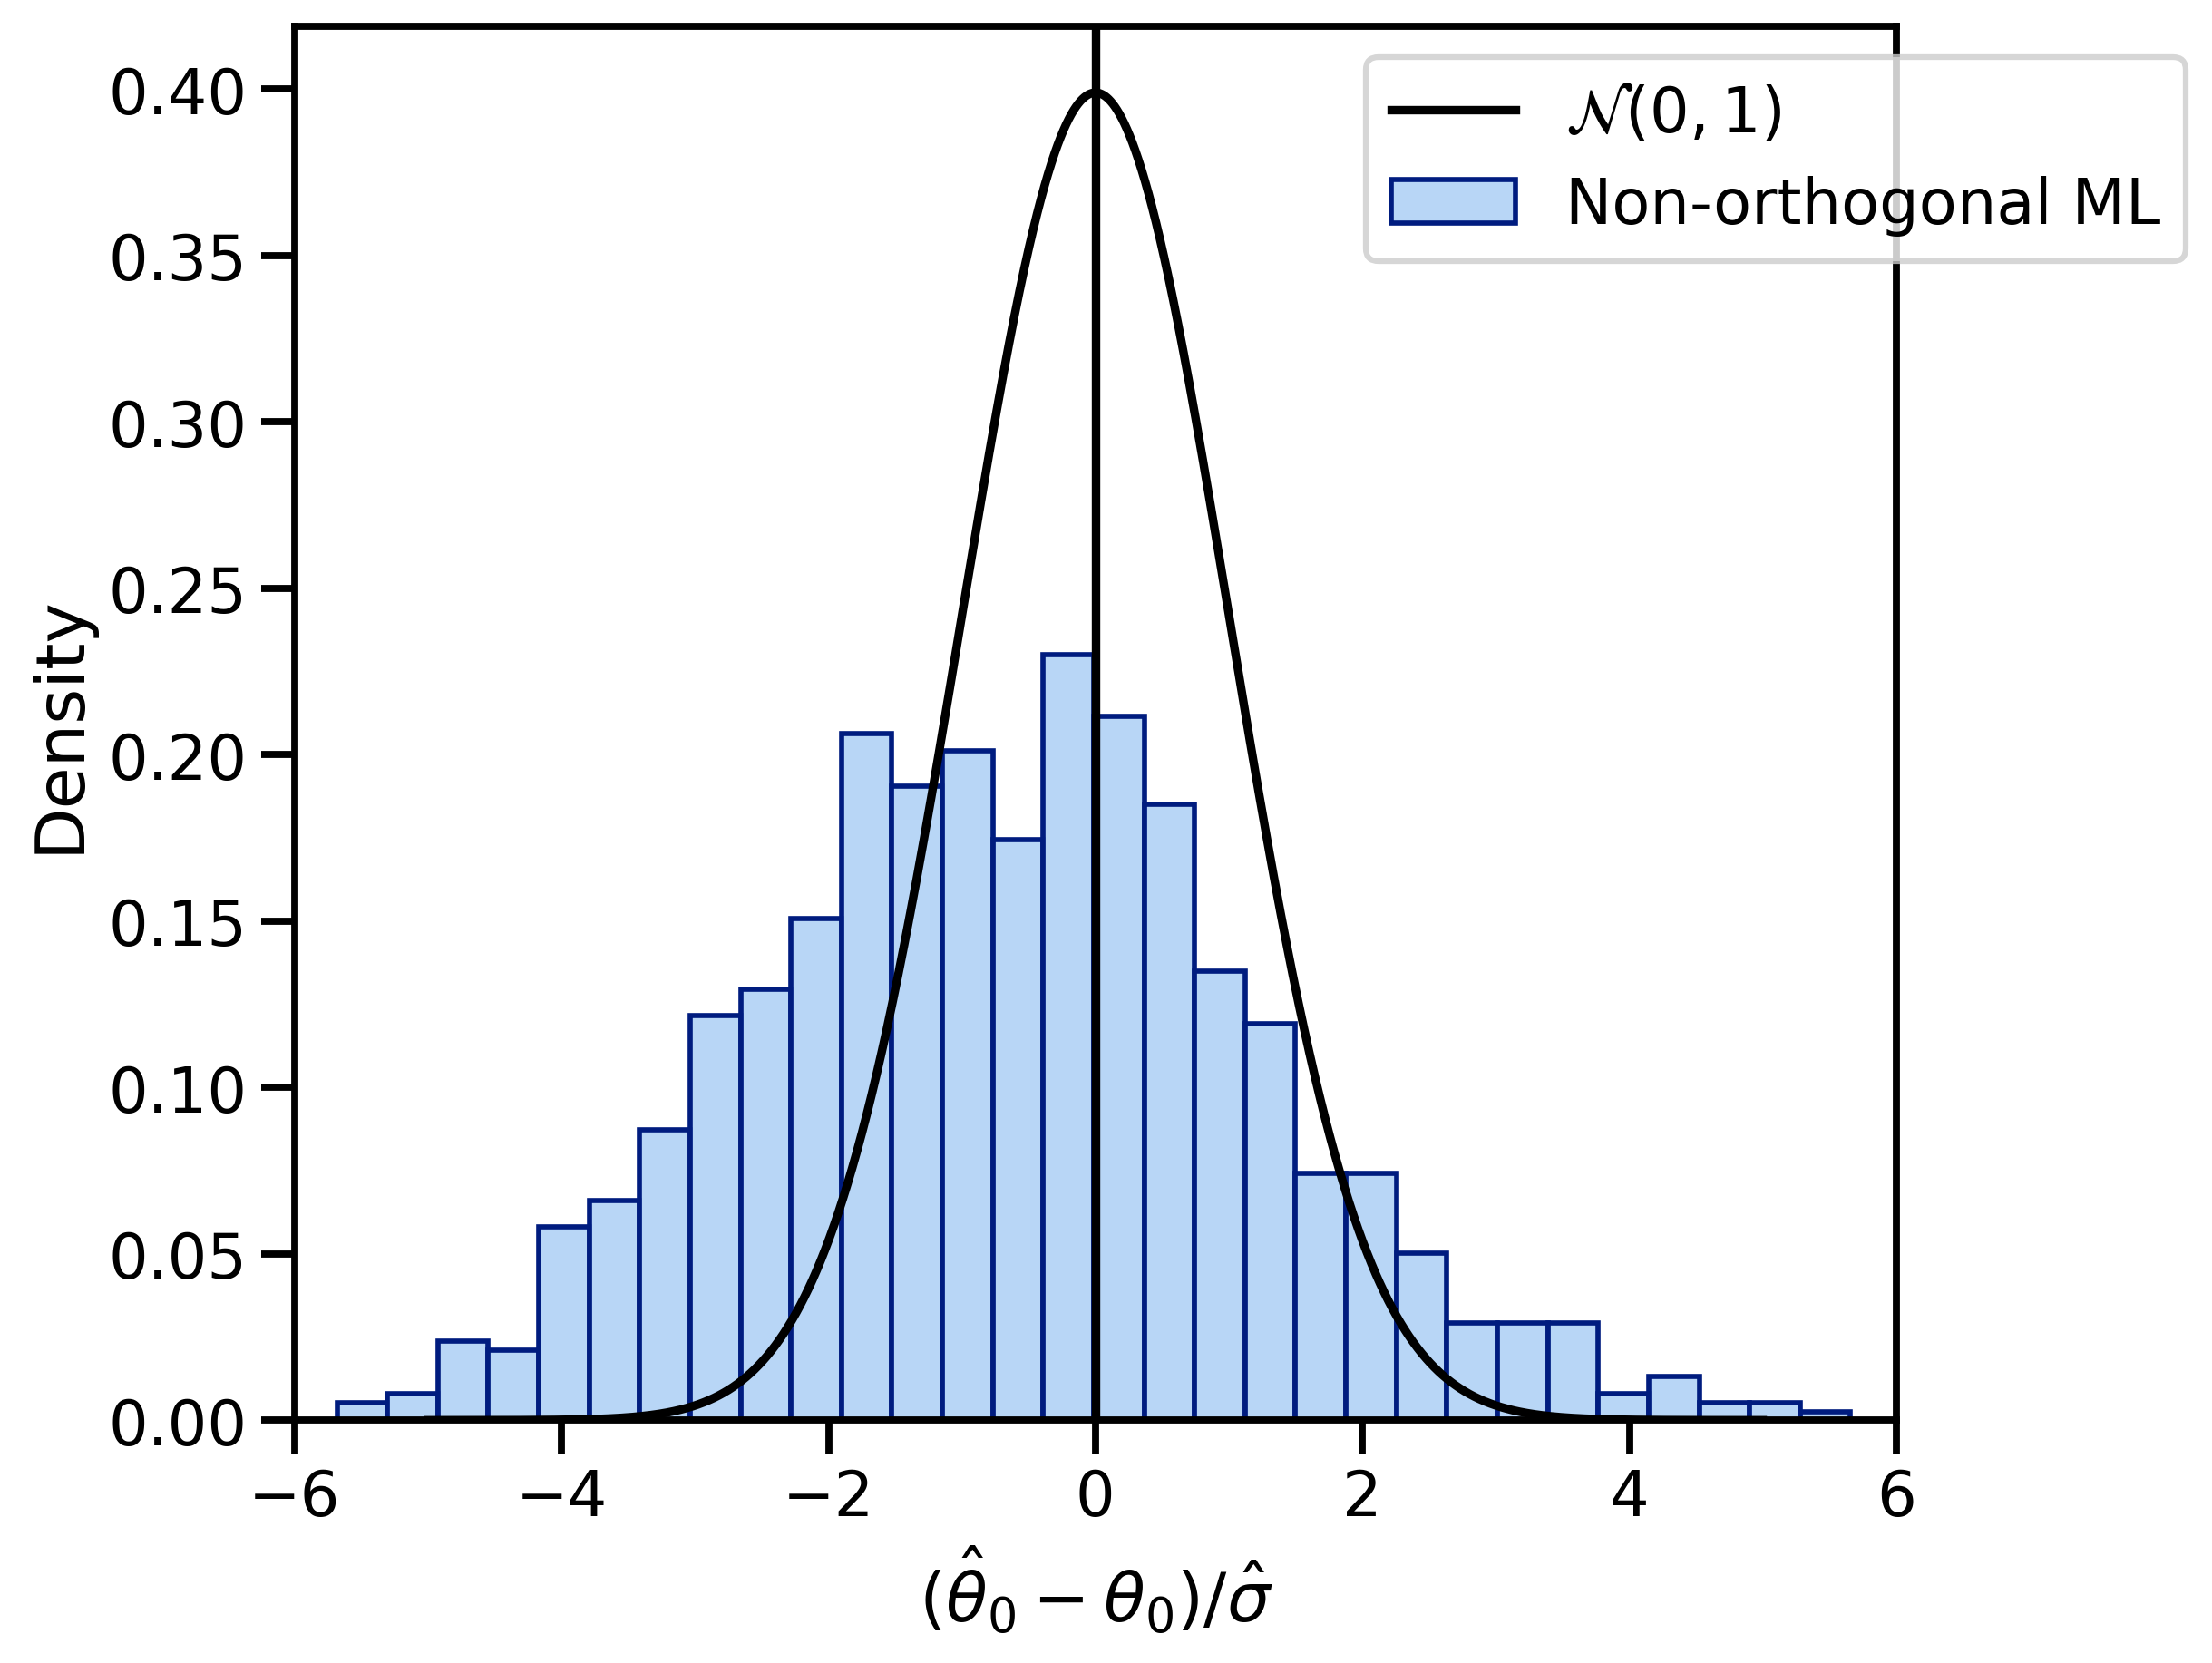

In [23]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 6)
fig_non_orth, ax = plt.subplots(constrained_layout=True)
ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                color=face_colors[0], edgecolor = edge_colors[0],
                stat='density', bins=30, label='Non-orthogonal ML')
ax.axvline(0., color='k')
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
ax.set_xlim([-6., 6.])
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$')
plt.show()